# **Imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [3]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

# **Data**

In [4]:
def load_image(image, SIZE):
    img = img_to_array(load_img(image)) / 255.  # Carga y normaliza entre 0 y 1
    img = tfi.resize(img, (SIZE, SIZE))  # Redimensiona

    # Si la imagen tiene 4 canales (RGBA), eliminamos el canal alfa
    if img.shape[-1] == 4:
        img = img[:, :, :3]  # Solo mantenemos los primeros 3 canales (RGB)

    # Si la imagen tiene solo 1 canal (escala de grises), convertimos a RGB
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)  # Repite el canal para obtener 3 canales

    return np.round(img, 4)


def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    # Definir las dimensiones correctas
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))  # Máscaras en escala de grises
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))  # Imágenes en RGB

    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)

        if mask:
            images[i] = img[:, :, :1]  # Solo tomamos un canal si es una máscara
        else:
            images[i] = img  # Mantiene RGB

    return images


In [5]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [6]:
SIZE = 256

In [7]:
root_path = '/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/modelo-tr/Datos/'
classes = sorted(os.listdir(root_path))
classes

['objetos', 'taza']

In [8]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])
triple_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_2.png")) for name in classes])

In [9]:
angles_df = pd.read_csv('/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/modelo-tr/Angulo_figuras_normalizado.csv', delimiter = ';')
angles_df.head()

,image_name,angle_magnitude_norm
0,figura5_frame_0.png,"0,089042"
1,figura5_frame_1.png,"0,107978"
2,figura5_frame_2.png,"0,090033"
3,figura5_frame_3.png,"0,076063"
4,figura5_frame_4.png,"0,05902"


In [10]:
angles_dict = dict(zip(angles_df['image_name'], angles_df['angle_magnitude_norm']))

In [11]:
image_paths = []
mask_paths = []

for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)


In [12]:
for class_path in double_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask1','')
        image_paths.append(img_path)
        mask_paths.append(path)


In [13]:
for class_path in triple_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask2','')
        image_paths.append(img_path)
        mask_paths.append(path)


In [14]:
angles = np.zeros(shape=(len(image_paths), 1))  # Un array de Nx1 donde N es el número de imágenes

# Llenar el array con los valores del diccionario de ángulos
for i, img_path in enumerate(image_paths):
    angles[i] = float(angles_dict[os.path.basename(img_path)].replace(",","."))

In [15]:
angles[2]

array([-0.242116])

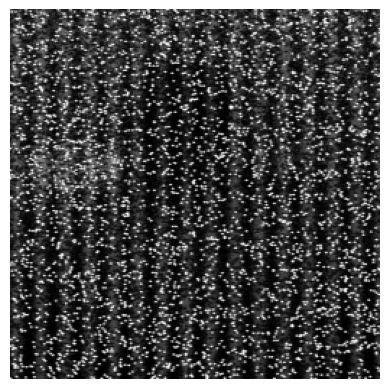

In [16]:
show_image(load_image(image_paths[0], SIZE))

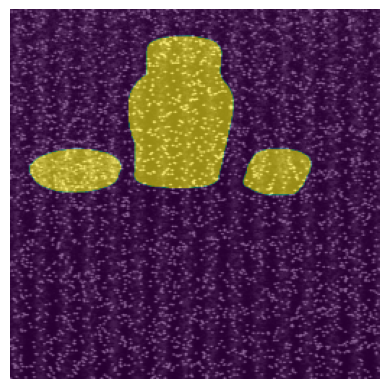

In [17]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

## **Data Work**

In [18]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

In [19]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

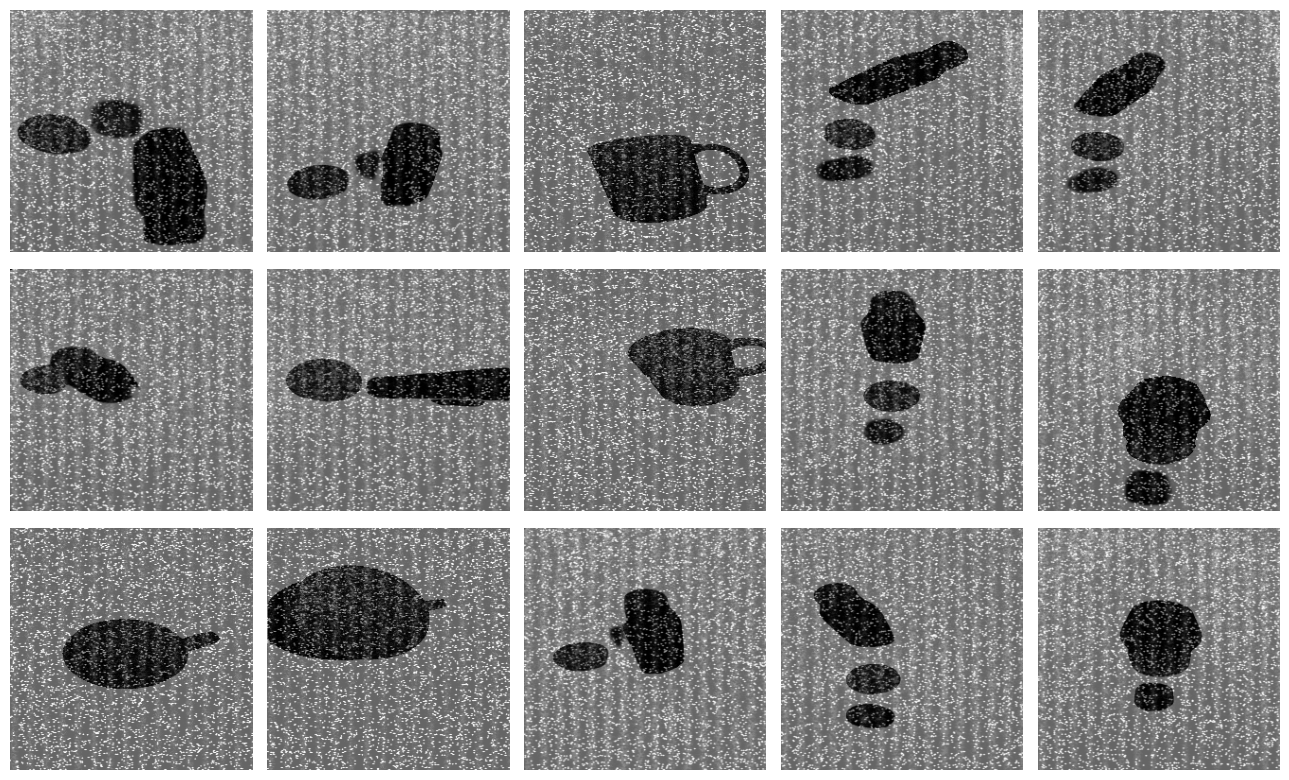

In [20]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

In [21]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [22]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **Encoder**

In [23]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [24]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [25]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# **Custom Callback**

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback

class ShowProgress(Callback):
    def __init__(self, images, masks,angles):
        super(ShowProgress, self).__init__()
        # Almacenamos las imágenes y las máscaras para mostrar durante el entrenamiento
        self.images = images
        self.masks = masks
        self.angles = angles

    def on_epoch_end(self, epoch, logs=None):
        # Seleccionamos un índice aleatorio para visualizar
        index = np.random.randint(0, len(self.images))

        # Obtenemos la imagen original, la máscara objetivo
        original_image = self.images[index]
        target_mask = self.masks[index]
        target_angle = self.angles[index]

        # Añadir el ángulo como canal adicional a la imagen
        image_with_angle = add_angle_as_channel(np.expand_dims(original_image, axis=0), np.array([target_angle]))

        # Predecir usando el modelo (incluyendo el ángulo)
        predicted_mask = self.model.predict(image_with_angle)[0]

        # Visualizamos las tres imágenes: original, objetivo y predicción
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Imagen original
        ax[0].imshow(original_image.squeeze(), cmap='gray')
        ax[0].set_title('Imagen Original')
        ax[0].axis('off')

        # Máscara objetivo
        ax[1].imshow(target_mask.squeeze(), cmap='gray')
        ax[1].set_title('Máscara Objetivo')
        ax[1].axis('off')

        # Máscara predicha
        ax[2].imshow(predicted_mask.squeeze(), cmap='gray')
        ax[2].set_title('Máscara Predicción')
        ax[2].axis('off')

        # Mostramos las imágenes
        plt.show()


# **Attention UNet**

In [33]:
from keras.layers import Concatenate
# Inputs
input_layer = Input(shape=(256, 256, 4))
# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])



a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    ModelCheckpoint("/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/modelo-tr/angulo_4rt_dimension.keras", save_best_only=True),
    ShowProgress(images=images, masks=masks, angles = angles),
    EarlyStopping(
        monitor='IoU',  # Observa la pérdida de validación
        patience=100,         # Número de épocas sin mejora antes de detener el entrenamiento
        restore_best_weights=True  # Restaura los mejores pesos obtenidos
    )
]



# **Training**

In [34]:
import numpy as np

def add_angle_as_channel(images, angles):
    # Mapear ángulos del rango [-1, 1] al rango [0, 255]
    angles_scaled = (angles + 1) * 127.5  # Escala y desplaza: -1 -> 0, 1 -> 255

    # Expandir el ángulo para que tenga las mismas dimensiones que la imagen en las dimensiones espaciales
    angles_expanded = np.expand_dims(angles_scaled, axis=-1)

    # Repetimos los valores del ángulo a lo largo de las dimensiones espaciales (alto y ancho de la imagen)
    angles_expanded = np.repeat(angles_expanded, images.shape[1], axis=1)  # Repite para la altura
    angles_expanded = np.repeat(angles_expanded, images.shape[2], axis=2)  # Repite para la anchura

    # Expandimos el ángulo para que tenga un canal adicional y sea compatible con las imágenes
    angles_expanded = np.expand_dims(angles_expanded, axis=-1)

    # Concatenamos las imágenes (con 3 canales) con el ángulo expandido (1 canal adicional)
    images_with_angle = np.concatenate([images, angles_expanded], axis=-1)

    return images_with_angle


In [35]:
BATCH_SIZE = 12

images_with_angle = add_angle_as_channel(images, angles)

results = model.fit(
    images_with_angle,
    masks,
    validation_split=0.2,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=cb
)


Output hidden; open in https://colab.research.google.com to view.

# **Evaluation**

In [36]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

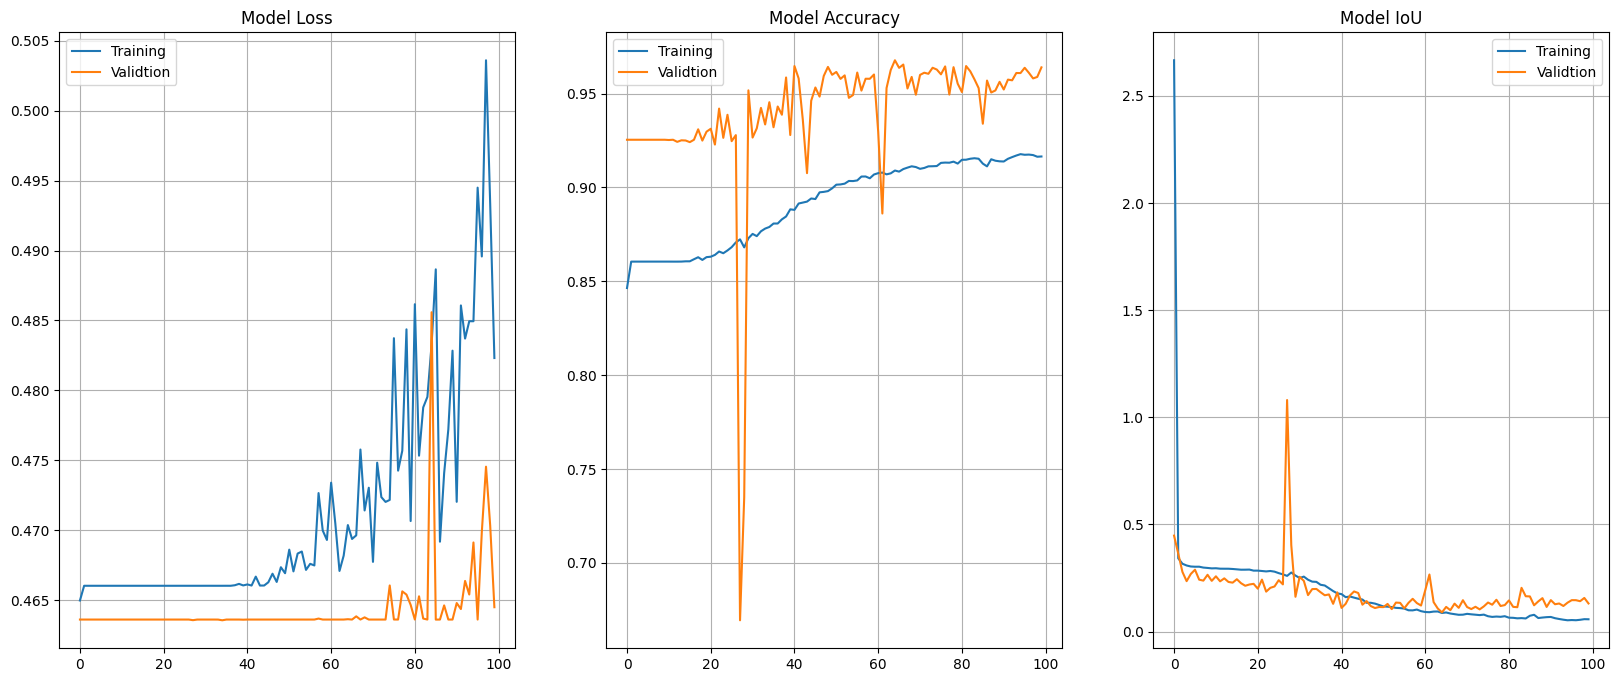

In [37]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

In [38]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        angle = angles[id]
        # Añadir el ángulo como canal adicional a la imagen
        image_with_angle = add_angle_as_channel(np.expand_dims(image, axis=0), np.array([angle]))


        pred_mask = model.predict(image_with_angle)


        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [39]:

pd.DataFrame(results.history).to_csv('/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/modelo-tr/training_history_angulo_4rt_capa.csv', index=False)

In [40]:
search_text = 'figura2_frame_96'

i = 0
for class_path in single_mask_paths:
    for path in class_path:
        i = i + 1
        if search_text in path :
          print(i)
          break


655


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


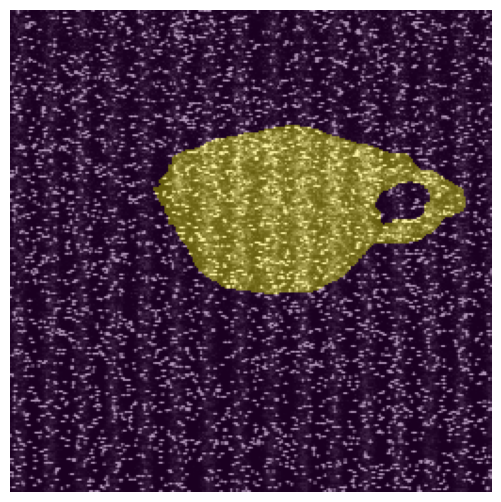

In [41]:
plt.figure(figsize=(20,25))
n=0
id = 655
plt.subplot(5,3,1)
image = images[id]
mask = masks[id]
angle = angles[id]
# Añadir el ángulo como canal adicional a la imagen
image_with_angle = add_angle_as_channel(np.expand_dims(image, axis=0), np.array([angle]))


pred_mask = model.predict(image_with_angle)
pred_mask = (pred_mask>0.5).astype('float')

show_mask(image, pred_mask)
n=0
plt.tight_layout()
plt.show()